# Segment the ISICs dataset with the Improved UNet

## Import Modules

In [99]:
import os
tf_device='/gpu:0'
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

2.5.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Segmentation
## Load Data

In [124]:
ds_data = tf.keras.preprocessing.image_dataset_from_directory(os.getcwd()+"\\ISIC2018_Task1-2_Training_Data\\ISIC2018_Task1-2_Training_Input_x2",
                                                    label_mode=None,
                                                    color_mode="rgb",
                                                    batch_size=2,
                                                    image_size=(512, 512),
                                                    shuffle=False)

ds_label = tf.keras.preprocessing.image_dataset_from_directory(os.getcwd()+"\\ISIC2018_Task1-2_Training_Data\\ISIC2018_Task1_Training_GroundTruth_x2",
                                                               label_mode=None,
                                                               color_mode="grayscale",
                                                               batch_size=2,
                                                               image_size=(512, 512),
                                                               shuffle=False)

Found 2594 files belonging to 1 classes.
Found 2594 files belonging to 1 classes.


## Data Preprocessing
Normalization is critical when data is combined from different institutes and scanners.
Steps:
 1. Normalize each modality of each patient independently
 2. Clip the resulting images at [-5, 5]
 3. Rescale to [0, 1] (With the non-brain region being set to 0)

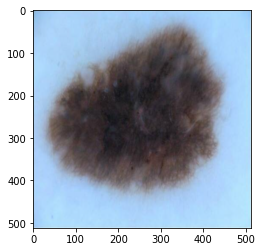

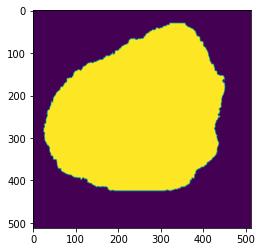

In [116]:
def normalize_image(image):
    mean = tf.math.reduce_mean(image)
    std = tf.math.reduce_std(image)
    s1 = tf.divide(tf.subtract(tf.cast(image, tf.float32), mean), std)
    s2 = tf.clip_by_value(s1, -5, 5)
    min = tf.math.reduce_min(s2)
    max = tf.math.reduce_max(s2)
    s3 = tf.divide(tf.subtract(s2, min), tf.subtract(max, min))
    return s3


# Shuffling
# indices = tf.range(start=0, limit=tf.data.experimental.cardinality(ds_data), dtype=tf.int32)
# idx = tf.random.shuffle(indices)
ds_data = ds_data.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

img1 = list(ds_data.take(1))[0][0]
img2 = list(ds_label.take(1))[0][0]
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
# ds_data = tf.gather(ds_data, idx)
# ds_label = tf.gather(ds_label, idx)
data_count = tf.data.experimental.cardinality(ds_data)
train_count = tf.cast(tf.floor(tf.cast(data_count, tf.float32) * 0.8, 2), tf.int64)
X_train, X_test = ds_data.take(train_count).as_numpy_iterator(), ds_data.skip(train_count).as_numpy_iterator()
y_train, y_test = ds_label.take(train_count).as_numpy_iterator(), ds_label.skip(train_count).as_numpy_iterator()

## Set Up Network Architecture

In [117]:
def make_model(width, height, channels):
    # Making an Improved UNet model based on their paper
    input_layer = layers.Input(shape=(width, height, channels))
    def down_path(in_layer, filter_size, stride_size):
        l1 = layers.Conv2D(filter_size, (3, 3), stride_size, padding="same")(in_layer)
        l2 = layers.BatchNormalization()(l1)
        l3 = layers.LeakyReLU(1e-2)(l2)
        # Context Module
        l4 = layers.Conv2D(filter_size, (3, 3), padding="same")(l3)
        l5 = layers.BatchNormalization()(l4)
        l6 = layers.LeakyReLU(1e-2)(l5)
        l7 = layers.Dropout(0.3)(l6)
        l8 = layers.Conv2D(filter_size, (3, 3), padding="same")(l7)
        l9 = layers.BatchNormalization()(l8)
        l10 = layers.LeakyReLU(1e-2)(l9)
        l11 = layers.Add()([l1, l10])
        return l11

    down_1 = down_path(input_layer, 16, (1, 1))
    down_2 = down_path(down_1, 32, (2, 2))
    down_3 = down_path(down_2, 64, (2, 2))
    down_4 = down_path(down_3, 128, (2, 2))
    down_5 = down_path(down_4, 256, (2, 2))

    def up_path(in_layer, concat_layer, filter_size):
        # Upsampling Module
        l1 = layers.UpSampling2D(size=(2, 2))(in_layer)
        l2 = layers.Conv2D(filter_size, (3, 3), padding="same")(l1)
        l3 = layers.BatchNormalization()(l2)
        l4 = layers.LeakyReLU(1e-2)(l3)
        l5 = layers.Concatenate()([concat_layer, l4])
        # Localization Module
        l6 = layers.Conv2D(filter_size, (3, 3), padding="same")(l5)
        l7 = layers.BatchNormalization()(l6)
        l8 = layers.LeakyReLU(1e-2)(l7)
        l9 = layers.Conv2D(filter_size, (3, 3), padding="same")(l8)
        l10 = layers.BatchNormalization()(l9)
        l11 = layers.LeakyReLU(1e-2)(l10)
        return l11

    up_1 = up_path(down_5, down_4, 128)
    up_2 = up_path(up_1, down_3, 64)
    up_3 = up_path(up_2, down_2, 32)
    # # Upsampling Module for the last part
    l1 = layers.UpSampling2D(size=(2, 2))(up_3)
    l2 = layers.Conv2D(16, (3, 3), padding="same")(l1)
    l3 = layers.BatchNormalization()(l2)
    l4 = layers.LeakyReLU(1e-2)(l3)
    l5 = layers.Concatenate()([down_1, l4])
    # # Connected to a normal convolution layer
    l6 = layers.Conv2D(32, (3, 3), padding="same")(l5)
    l7 = layers.BatchNormalization()(l6)
    l8 = layers.LeakyReLU(1e-2)(l7)

    # Segmentation
    seg1_1 = layers.Conv2D(1, (3, 3), padding="same")(up_2)
    seg1_2 = layers.BatchNormalization()(seg1_1)
    seg1_3 = layers.LeakyReLU(1e-2)(seg1_2)
    seg1_4 = layers.UpSampling2D(size=(2, 2))(seg1_3)

    seg2_1 = layers.Conv2D(1, (3, 3), padding="same")(up_3)
    seg2_2 = layers.BatchNormalization()(seg2_1)
    seg2_3 = layers.LeakyReLU(1e-2)(seg2_2)

    seg3_1 = layers.Conv2D(1, (3, 3), padding="same")(up_3)
    seg3_2 = layers.BatchNormalization()(seg3_1)
    seg3_3 = layers.LeakyReLU(1e-2)(seg3_2)

    # Adding the segmentations together
    add_1 = layers.Add()([seg1_4, seg2_3])
    add_2 = layers.Add()([add_1, seg3_3])

    output_layer = layers.Conv2D(1, (1, 1), activation="sigmoid")(add_2)
    return tf.keras.Model(inputs=[input_layer], outputs=[output_layer])


In [118]:
## Compile model

In [119]:
def dice_similarity_coefficient(y_true, y_pred):
    top = tf.multiply(2., (tf.reduce_sum(y_true * y_pred, axis=(1,2,3))))
    bottom = tf.reduce_sum(y_true, axis=(1,2,3)) + tf.reduce_sum(y_pred, axis=(1,2,3))
    coefficient = top / (bottom + 1e-7) # to avoid dividing by 0
    return coefficient

model = make_model(512, 512, 3)
model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4), # TODO: more parameters here
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=dice_similarity_coefficient
)

## Train Model

In [120]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    )

ValueError: `y` argument is not supported when using python generator as input.